<a href="https://colab.research.google.com/github/eichhorn-lab/hnRNPR_eRRM1/blob/main/COSMIC_hnRNPR_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Plotting COSMIC mutation data in google colab | Created by CDE 12/19/2024

Each time you open or reconnect the notebook, you will need to upload your data, then Runtime > Run all to run

In [1]:
#@title Print statistics from COSMIC input file

import pandas as pd
import os
import matplotlib.pyplot as plt
import re

# Ensure the 'tables' and 'plots' directories exist
os.makedirs('tables', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# Read the input CSV file
input_file = '/content/hnRNPR_COSMIC_total.csv'
df = pd.read_csv(input_file)

# Define a function to categorize mutations with stricter criteria
def categorize_mutation(mutation):
    if mutation == "p.?":
        return "Unknown"
    elif pd.notna(mutation) and mutation.startswith("p.") and mutation[-1] == "=":
        return "Silent"
    elif pd.notna(mutation) and mutation.startswith("p.") and "*" in mutation:
        return "Stop"
    elif pd.notna(mutation) and re.match(r"^p\.[A-Z]\d+[A-Z]$", mutation):  # Updated regex for Missense
        return "Missense"
    elif pd.notna(mutation) and "fs" in mutation:
        return "Frameshift"
    else:
        return "Other"


# Total number of rows (excluding the header)
total_rows = len(df)

# Apply the categorization function
df['Mutation Type'] = df['AA Mutation'].apply(categorize_mutation)

# Get counts and percentages of each mutation type
mutation_type_counts = df['Mutation Type'].value_counts()
mutation_type_percentages = (mutation_type_counts / total_rows) * 100

mutation_type_summary = pd.DataFrame({
    "Count": mutation_type_counts,
    "Percentage": mutation_type_percentages
})

# Add total rows and sums
mutation_type_summary.loc["Total Rows (Before Classification)"] = [total_rows, 100]
mutation_type_summary.loc["Sum of Mutation Types"] = [mutation_type_counts.sum(), mutation_type_percentages.sum()]

# Summarize primary tissue and histology subtype
primary_tissue_counts = df['Primary Tissue'].value_counts()
primary_tissue_percentages = (primary_tissue_counts / total_rows) * 100

primary_tissue_summary = pd.DataFrame({
    "Count": primary_tissue_counts,
    "Percentage": primary_tissue_percentages
})

histology_subtype_counts = df['Histology Subtype 1'].value_counts()
histology_subtype_percentages = (histology_subtype_counts / total_rows) * 100

histology_subtype_summary = pd.DataFrame({
    "Count": histology_subtype_counts,
    "Percentage": histology_subtype_percentages
})

# Save mutations that do not fit the defined categories
other_mutations = df[df['Mutation Type'] == "Other"]

# Save identified missense mutations to a CSV file for comparison
missense_mutations = df[df['Mutation Type'] == "Missense"]
missense_mutations_file = 'tables/missense_mutations.csv'
missense_mutations[['AA Mutation']].to_csv(missense_mutations_file, index=False)

# Print summaries
print("Total Rows (Before Classification):", total_rows)
print("\nMutation Type Summary:")
print(mutation_type_summary)

print("\nPrimary Tissue Counts and Percentages:")
print(primary_tissue_summary)

print("\nHistology Subtype Counts and Percentages:")
print(histology_subtype_summary)

print("\nMutations that do not fit defined categories:")
print(other_mutations[['AA Mutation']])

# Save results to CSV files
mutation_type_summary_file = 'tables/mutation_type_summary.csv'
primary_tissue_summary_file = 'tables/primary_tissue_summary.csv'
histology_subtype_summary_file = 'tables/histology_subtype_summary.csv'
other_mutations_file = 'tables/other_mutations.csv'

mutation_type_summary.to_csv(mutation_type_summary_file, index_label="Mutation Type")
primary_tissue_summary.to_csv(primary_tissue_summary_file, index_label='Primary Tissue')
histology_subtype_summary.to_csv(histology_subtype_summary_file, index_label='Histology Subtype 1')
other_mutations[['AA Mutation']].to_csv(other_mutations_file, index=False)

print(f"\nMutation type summary saved to: {mutation_type_summary_file}")
print(f"Primary tissue summary saved to: {primary_tissue_summary_file}")
print(f"Histology subtype summary saved to: {histology_subtype_summary_file}")
print(f"Other mutations saved to: {other_mutations_file}")
print(f"Missense mutations saved to: {missense_mutations_file}")

# Function to plot and save pie charts
def plot_and_save_pie_chart(data, labels, title, output_file):
    plt.figure(figsize=(8, 8))
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
    plt.savefig(output_file, format='svg')
    plt.close()
    print(f"Pie chart saved to {output_file}")

# Plot and save pie charts for mutation type, primary tissue, and histology subtype
plot_and_save_pie_chart(mutation_type_counts, mutation_type_counts.index, "Mutation Type Distribution", 'plots/hnRNPR_all_mutation_type_distribution.svg')
plot_and_save_pie_chart(primary_tissue_counts, primary_tissue_counts.index, "Primary Tissue Distribution", 'plots/hnRNPR_all_primary_tissue_distribution.svg')
plot_and_save_pie_chart(histology_subtype_counts, histology_subtype_counts.index, "Histology Subtype Distribution", 'plots/hnRNPR_all_histology_subtype_distribution.svg')


Total Rows (Before Classification): 513

Mutation Type Summary:
                                    Count  Percentage
Mutation Type                                        
Unknown                             225.0   43.859649
Missense                            172.0   33.528265
Silent                               94.0   18.323587
Stop                                 17.0    3.313840
Other                                 5.0    0.974659
Total Rows (Before Classification)  513.0  100.000000
Sum of Mutation Types               513.0  100.000000

Primary Tissue Counts and Percentages:
                             Count  Percentage
Primary Tissue                                
Large intestine                 72   14.035088
Liver                           49    9.551657
Skin                            46    8.966862
Upper aerodigestive tract       41    7.992203
Breast                          39    7.602339
Lung                            35    6.822612
Stomach                         33

In [2]:
#@title Classify mutation sites by hnRNPR domain and mutation type

import pandas as pd
import re

# Domain topology definition
domain_topology = {
    "N-terminus": (1, 23),
    "NaB": (24, 115),
    "Linker1": (116, 121),
    "eRRM1": (122, 242),
    "Linker2": (243, 246),
    "RRM2": (247, 325),
    "Linker3": (326, 333),
    "RRM3": (334, 408),
    "Helix3": (409, 431),
    "RGG": (432, 700)
}

# Function to categorize mutation based on residue number
def categorize_mutation(residue_number):
    for domain, (start, end) in domain_topology.items():
        if start <= residue_number <= end:
            return domain
    return "Unknown"

# Function to determine mutation type
def determine_mutation_type(aa_mutation):
    if "dup" in aa_mutation:
        return "duplication"
    elif "p.?" in aa_mutation:
        return "noncoding"
    elif "del" in aa_mutation:
        return "deletion"
    elif "?" in aa_mutation:
        return "unknown"
    elif "*" in aa_mutation:
        return "truncation"
    elif "=" in aa_mutation:
        return "silent"
    elif re.match(r"p\.[A-Z](\d+)[A-Z]$", aa_mutation):
        return "missense"
    return "unknown"

# Load the CSV file with mutation data
input_file = '/content/hnRNPR_COSMIC_total.csv'
df = pd.read_csv(input_file)

# Function to extract residue number from AA Mutation (e.g., p.T630A or p.K636= -> 630 or 636)
def extract_residue_number(aa_mutation):
    match = re.search(r"p\.(\D?)(\d+)(\D*)", aa_mutation)
    if match:
        residue_number = int(match.group(2))
        return residue_number
    return None

# List to store categorized mutation data
categorized_mutations = []

# Process each row and categorize the mutation
for index, row in df.iterrows():
    aa_mutation = row['AA Mutation']
    residue_number = extract_residue_number(aa_mutation)
    mutation_type = determine_mutation_type(aa_mutation)

    if residue_number:
        domain = categorize_mutation(residue_number)
        # Add the result to the categorized mutations list
        categorized_mutations.append({
            'Gene Name': row['Gene Name'],
            'Transcript': row['Transcript'],
            'AA Mutation': aa_mutation,
            'Residue Number': residue_number,
            'Domain': domain,
            'Mutation Type': mutation_type,
            'Sample Name': row['Sample Name'],
            'Sample ID': row['Sample ID'],
            'Histology': row['Histology'],
            'Somatic Status': row['Somatic Status'],
            'Primary Tissue': row['Primary Tissue'],
            'Histology Subtype 1': row['Histology Subtype 1']
        })

# Create a DataFrame from the categorized mutations
categorized_df = pd.DataFrame(categorized_mutations)

# Save the categorized data to a new CSV file
output_file = '/content/categorized_hnRNPR_mutations.csv'
categorized_df.to_csv(output_file, index=False)

# Count mutation types
mutation_counts = categorized_df['Mutation Type'].value_counts()
unknown_count = len(df) - len(categorized_df)

print("Mutation Type Counts:")
for mutation_type, count in mutation_counts.items():
    print(f"{mutation_type}: {count}")

print(f"Not categorized: {unknown_count}")

print(f"Categorized mutations with mutation types saved to {output_file}")


Mutation Type Counts:
missense: 172
silent: 94
truncation: 16
deletion: 4
duplication: 1
unknown: 1
Not categorized: 225
Categorized mutations with mutation types saved to /content/categorized_hnRNPR_mutations.csv


Total rows in the input file: 288
Total missense mutations in the input file: 172
Rows excluded (not missense mutations): 116
Sum of missense mutations across all domains: 172

Number of Missense Mutations Per Domain:
Domain
RGG           66
eRRM1         29
RRM3          25
RRM2          22
NaB           21
Helix3         3
Linker3        2
Linker1        2
N-terminus     2
Name: count, dtype: int64


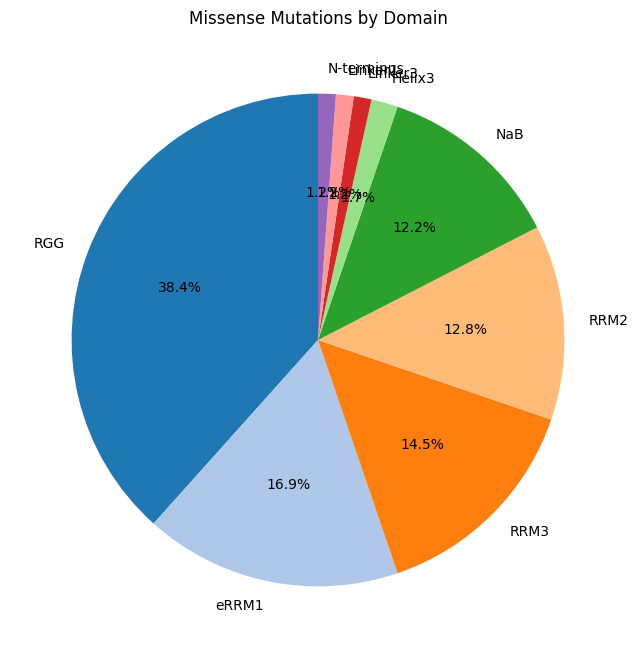

Pie chart saved to plots/hnRNPR_all_missense_mutations_pie_chart.svg


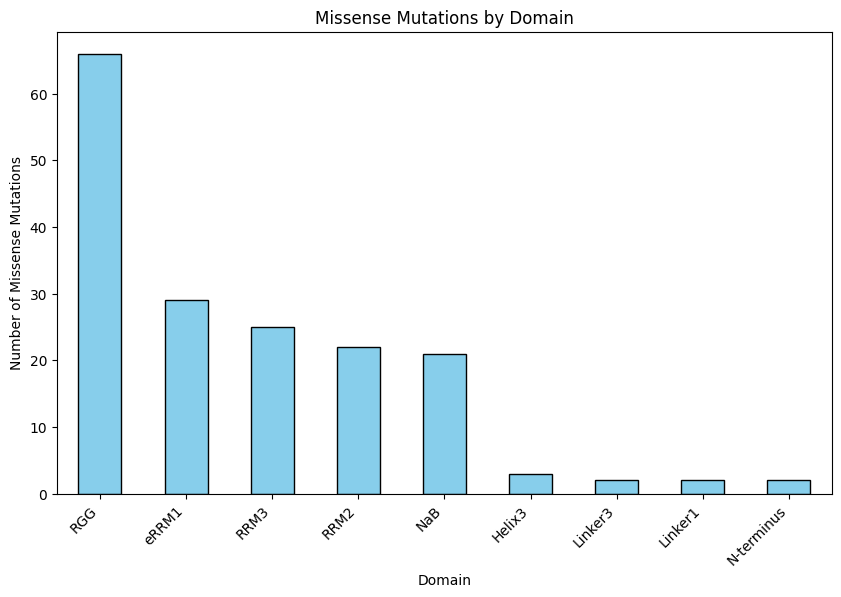

Bar graph saved to plots/hnRNPR_all_missense_mutations_bar_graph.png


In [9]:
#@title Plot pie chart and bar plot of missense mutations by hnRNPR region

import pandas as pd
import re
import matplotlib.pyplot as plt
import os

# Create a directory for plots if it doesn't exist
os.makedirs('plots', exist_ok=True)

# File containing the categorized mutations
input_file = '/content/categorized_hnRNPR_mutations.csv'

# Load the categorized mutations file
categorized_df = pd.read_csv(input_file)

# Total number of rows in the input file
total_rows = len(categorized_df)

# Function to identify missense mutations (e.g., A233G but not A233G* or A233Gfs*)
def is_missense_mutation(aa_mutation):
    return re.match(r"p\.[A-Z](\d+)[A-Z]$", aa_mutation) is not None

# Filter for missense mutations
missense_mutations = categorized_df[categorized_df['AA Mutation'].apply(is_missense_mutation)]

# Number of missense mutations
total_missense_mutations = len(missense_mutations)

# Rows excluded (not missense mutations)
excluded_rows = total_rows - total_missense_mutations

# Count the number of missense mutations per domain
missense_counts = missense_mutations['Domain'].value_counts()

# Total sum of mutations in domains
total_mutations_in_domains = missense_counts.sum()

# Print statistics
print(f"Total rows in the input file: {total_rows}")
print(f"Total missense mutations in the input file: {total_missense_mutations}")
print(f"Rows excluded (not missense mutations): {excluded_rows}")
print(f"Sum of missense mutations across all domains: {total_mutations_in_domains}")
print("\nNumber of Missense Mutations Per Domain:")
print(missense_counts)

# Plot the data in a pie chart
plt.figure(figsize=(8, 8))
missense_counts.plot.pie(autopct='%1.1f%%', startangle=90, labels=missense_counts.index, colors=plt.cm.tab20.colors)
plt.title('Missense Mutations by Domain')
plt.ylabel('')  # Remove y-axis label for clarity
pie_chart_file = 'plots/hnRNPR_all_missense_mutations_pie_chart.svg'
plt.savefig(pie_chart_file, bbox_inches='tight')
plt.show()
print(f"Pie chart saved to {pie_chart_file}")

# Plot the data in a bar graph
plt.figure(figsize=(10, 6))
missense_counts.plot.bar(color='skyblue', edgecolor='black')
plt.title('Missense Mutations by Domain')
plt.xlabel('Domain')
plt.ylabel('Number of Missense Mutations')
plt.xticks(rotation=45, ha='right')
bar_graph_file = 'plots/hnRNPR_all_missense_mutations_bar_graph.png'
plt.savefig(bar_graph_file, bbox_inches='tight')
plt.show()
print(f"Bar graph saved to {bar_graph_file}")
# Save identified missense mutations to a CSV file for comparison
missense_mutations[['AA Mutation']].to_csv('missense_mutations_byregion.csv', index=False)



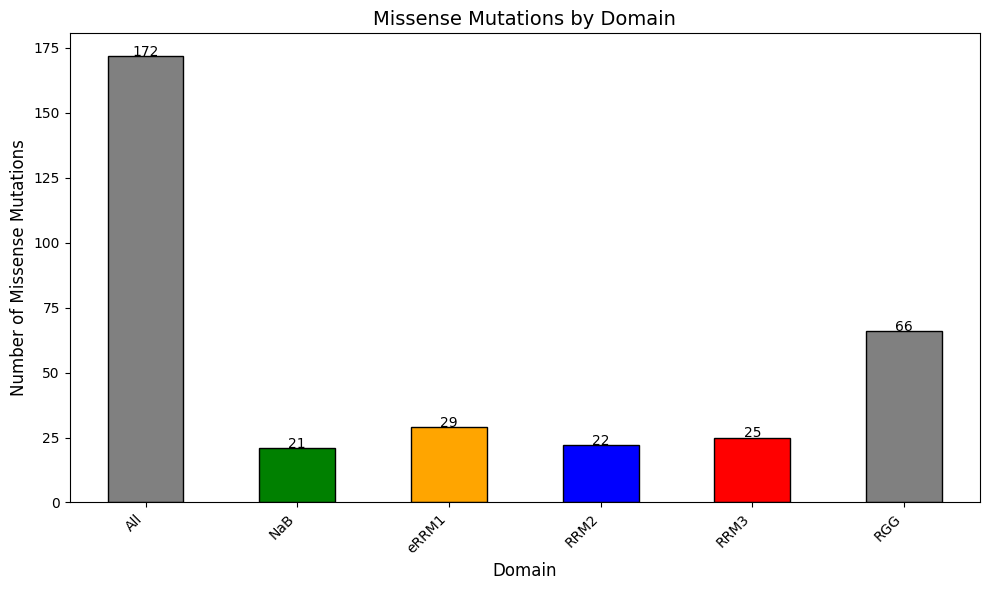

Bar graph saved to plots/hnRNPR_all_missense_mutations_bar_graph_with_counts.svg


In [4]:
#@title Plot bar plot of hnRNPR missense mutations by structured domain

import pandas as pd
import re
import matplotlib.pyplot as plt
import os

# Create a directory for plots if it doesn't exist
os.makedirs('plots', exist_ok=True)

# File containing the categorized mutations
input_file = '/content/categorized_hnRNPR_mutations.csv'

# Load the categorized mutations file
categorized_df = pd.read_csv(input_file)

# Total number of rows in the input file
total_rows = len(categorized_df)

# Function to identify missense mutations (e.g., A233G but not A233G* or A233Gfs*)
def is_missense_mutation(aa_mutation):
    return re.match(r"p\.[A-Z](\d+)[A-Z]$", aa_mutation) is not None

# Filter for missense mutations
missense_mutations = categorized_df[categorized_df['AA Mutation'].apply(is_missense_mutation)]

# Count the number of missense mutations per domain
missense_counts = missense_mutations['Domain'].value_counts()

# Reorder x-axis data points (same as previous code)
desired_order = ["All", "Total", "N-terminus", "NaB", "linker 1", "eRRM1", "linker 2", "RRM2", "linker 3", "RRM3", "RGG"]

# Filter out domains not present in the data
existing_order = [domain for domain in desired_order if domain in missense_counts.index]

# Add "All" category with the total count of all missense mutations
all_count = missense_counts.sum()

# Use pd.concat to add the "All" category at the beginning
all_category = pd.Series([all_count], index=["All"])
missense_counts = pd.concat([all_category, missense_counts])

# Reindex with existing categories and "All" at the start
missense_counts = missense_counts.reindex([desired_order[0]] + existing_order[1:], fill_value=0)

# Define custom colors for the domains
domain_colors = {
    'All': 'gray',  # Color for "All"
    'N-terminus': 'black',
    'linker 1': 'black',
    'linker 2': 'black',
    'linker 3': 'black',
    'NaB': 'green',
    'eRRM1': 'orange',
    'RRM2': 'blue',
    'RRM3': 'red',
    'RGG': 'gray'
}

# Map the colors for the domains
colors = [domain_colors.get(domain, 'skyblue') for domain in missense_counts.index]

# Plot the data in a bar graph
plt.figure(figsize=(10, 6))
ax = missense_counts.plot.bar(color=colors, edgecolor='black')

# Add title and labels
plt.title('Missense Mutations by Domain', fontsize=14)
plt.xlabel('Domain', fontsize=12)
plt.ylabel('Number of Missense Mutations', fontsize=12)
plt.xticks(rotation=45, ha='right', color='black')  # Set x-axis labels to black
plt.yticks(color='black')

# Display the count at the top of each bar
for i, value in enumerate(missense_counts):
    ax.text(i, value + 0.05, str(value), ha='center', fontsize=10, color='black')

# Save and show the plot
bar_graph_file = 'plots/hnRNPR_all_missense_mutations_bar_graph_with_counts.svg'
plt.tight_layout()
plt.savefig(bar_graph_file, bbox_inches='tight')
plt.show()

print(f"Bar graph saved to {bar_graph_file}")


'ER-PR-positive carcinoma': '#FF69B4'
'ER-PR-HER-positive carcinoma': '#FF1493'
'HER-positive carcinoma': '#C71585'
'Tubular': '#D8BFD8'
'Superficial spreading': '#40E0D0'
'Metaplastic carcinoma': '#FF69B4'
'Luminal NS carcinoma': '#FFB6C1'
'Ductal carcinoma': '#FF0000'
'Acute lymphoblastic T cell leukaemia': '#800080'
'Diffuse large B cell lymphoma': '#6A5ACD'
'Acute myeloid leukaemia': '#8A2BE2'
'Hodgkin lymphoma': '#4B0082'
'Chronic lymphocytic leukaemia-small lymphocytic lymphoma': '#9932CC'
'Mycosis fungoides-Sezary syndrome': '#8A2BE2'
'Adenocarcinoma': '#1E90FF'
'Squamous cell carcinoma': '#FFA500'
'Mixed adenosquamous carcinoma': '#FFD700'
'Endometrioid carcinoma': '#228B22'
'Astrocytoma Grade IV': '#DAA520'
'Small cell carcinoma': '#6A5ACD'
'Intestinal adenocarcinoma': '#FF7F0E'
'Clear cell renal cell carcinoma': '#4169E1'
'Large cell neuroendocrine carcinoma': '#32CD32'
'Neoplasm': '#8B4513'
'NS': '#505050'
'Atypical': '#696969'
'Mixed': '#D3D3D3'
'Pleomorphic': '#D3D3D3'
'Ba

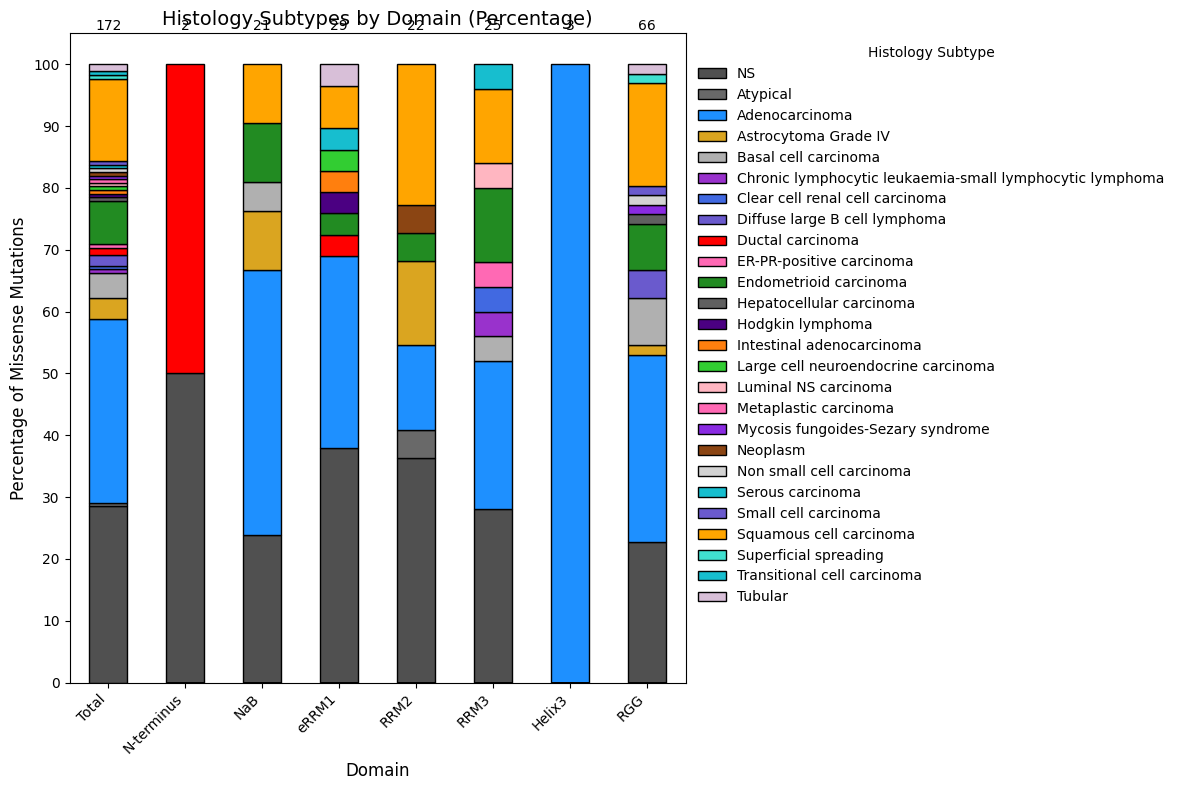

Percentage bar graph of histology subtypes (with custom colors and totals) saved to plots/hnRNPR_histology_subtypes_by_domain_percentage_colored_bar_graph.svg


In [5]:
#@title Generate plot of cancer histology subtype for each structured hnRNPR domain

import pandas as pd
import re
import matplotlib.pyplot as plt
import os

# Create a directory for plots if it doesn't exist
os.makedirs('plots', exist_ok=True)

# File containing the categorized mutations
input_file = '/content/categorized_hnRNPR_mutations.csv'

# Load the categorized mutations file
categorized_df = pd.read_csv(input_file)

# Total number of rows in the input file
total_rows = len(categorized_df)

# Function to identify missense mutations (e.g., A233G but not A233G* or A233Gfs*)
def is_missense_mutation(aa_mutation):
    return re.match(r"p\.[A-Z](\d+)[A-Z]$", aa_mutation) is not None

# Filter for missense mutations
missense_mutations = categorized_df[categorized_df['AA Mutation'].apply(is_missense_mutation)]

# Count the number of missense mutations per domain
missense_counts = missense_mutations['Domain'].value_counts()

# Analyze histology subtype distribution within each domain
histology_domain_counts = missense_mutations.groupby(['Domain', 'Histology Subtype 1']).size().unstack(fill_value=0)

# Compute percentages for each domain
histology_domain_percentages = histology_domain_counts.div(histology_domain_counts.sum(axis=1), axis=0) * 100

# Add an "All Data" row (total percentages across all domains)
total_counts = histology_domain_counts.sum(axis=0)  # Total counts across all domains
total_percentages = (total_counts / total_counts.sum()) * 100
histology_domain_percentages.loc["Total"] = total_percentages

# Add the "Total Count" row for labels
total_counts_per_domain = histology_domain_counts.sum(axis=1)
total_counts_per_domain.loc["Total"] = total_counts.sum()

# Reorder x-axis data points
desired_order = ["Total", "N-terminus", "NaB", "linker 1", "eRRM1", "linker 2", "RRM2", "linker 3", "RRM3", "Helix3", "RGG"]

# Filter out domains not present in the data
existing_order = [domain for domain in desired_order if domain in histology_domain_percentages.index]

# Reindex with existing categories only
histology_domain_percentages = histology_domain_percentages.reindex(existing_order, fill_value=0)
total_counts_per_domain = total_counts_per_domain.reindex(existing_order, fill_value=0)

# Reorder y-axis data (subtypes) to ensure NS and Atypical are at the bottom
subtype_order = ["NS", "Atypical"] + [col for col in histology_domain_percentages.columns if col not in ["NS", "Atypical"]]
histology_domain_percentages = histology_domain_percentages[subtype_order]

# Define colors for NS and Atypical as grayscale, others as vibrant colors
# Dictionary with cancer types and their corresponding colors
custom_colors = {
    # Breast Cancers (Shades of Pink)
    'ER-PR-positive carcinoma': '#FF69B4',  # Hot Pink
    'ER-PR-HER-positive carcinoma': '#FF1493',  # Deep Pink
    'HER-positive carcinoma': '#C71585',  # Medium Violet Red
    'Tubular': '#D8BFD8',  # Thistle
    'Superficial spreading': '#40E0D0',  # Turquoise
    'Metaplastic carcinoma': '#FF69B4',  # Hot Pink
    'Luminal NS carcinoma': '#FFB6C1',  # Light Pink
    'Ductal carcinoma': '#FF0000',  # Red

    # Blood Cancers (Shades of Purple)
    'Acute lymphoblastic T cell leukaemia': '#800080',  # Purple
    'Diffuse large B cell lymphoma': '#6A5ACD',  # Slate Blue
    'Acute myeloid leukaemia': '#8A2BE2',  # Blue Violet
    'Hodgkin lymphoma': '#4B0082',  # Indigo
    'Chronic lymphocytic leukaemia-small lymphocytic lymphoma': '#9932CC',  # Dark Orchid
    'Mycosis fungoides-Sezary syndrome': '#8A2BE2',  # Blue Violet

    # Other Cancers (Shades of Blue, Green, Orange)
    'Adenocarcinoma': '#1E90FF',  # Dodger Blue
    'Squamous cell carcinoma': '#FFA500',  # Orange
    'Mixed adenosquamous carcinoma': '#FFD700',  # Gold
    'Endometrioid carcinoma': '#228B22',  # Forest Green
    'Astrocytoma Grade IV': '#DAA520',  # yellow
    'Small cell carcinoma': '#6A5ACD',  # Slate Blue
    'Intestinal adenocarcinoma': '#FF7F0E',  # Orange
    'Clear cell renal cell carcinoma': '#4169E1',  # Royal Blue
    'Large cell neuroendocrine carcinoma': '#32CD32',  # Lime Green

    # NS, Atypical, Mixed (Shades of Gray)
    'Neoplasm': '#8B4513',  # Saddle Brown
    'NS': '#505050',  # Light Gray
    'Atypical': '#696969',  # Dark Gray
    'Mixed': '#D3D3D3',  # Light Gray
    'Pleomorphic': '#D3D3D3',  # Light Gray
    'Basal cell carcinoma': '#B0B0B0',  # Light Gray
    'Hepatocellular carcinoma': '#606060',  # Dark Gray
    'Non small cell carcinoma': '#D3D3D3',  # Light Gray
    'Papillary carcinoma': '#40E0D0',  # Turquoise
    'Epithelioid cell': '#FF6347',  # Tomato Red
}

# Print the dictionary to verify the colors
for cancer_type, color in custom_colors.items():
    print(f"'{cancer_type}': '{color}'")


# Map histology subtypes to colors
colors = [custom_colors.get(col, '#17becf') for col in histology_domain_percentages.columns]  # Default to teal for unassigned

# Plot the normalized histology subtype distribution as a stacked bar graph
ax = histology_domain_percentages.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=colors,
    edgecolor='black'
)

# Add total counts as labels above each bar
for i, count in enumerate(total_counts_per_domain):
    if not pd.isna(count):  # Skip NaN values
        ax.text(
            i, 105,  # Position above the bar
            f"{int(count)}",
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

plt.title('Histology Subtypes by Domain (Percentage)', fontsize=14)
plt.xlabel('Domain', fontsize=12)
plt.ylabel('Percentage of Missense Mutations', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(range(0, 101, 10))  # Ensure y-axis is 0-100 for percentage

# Move legend outside and adjust layout
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title='Histology Subtype',
    frameon=False
)  # Move legend outside and remove frame
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit legend

# Save the plot
bar_graph_histology_percentage_file = 'plots/hnRNPR_histology_subtypes_by_domain_percentage_colored_bar_graph.svg'
plt.savefig(bar_graph_histology_percentage_file, bbox_inches='tight')
plt.show()

print(f"Percentage bar graph of histology subtypes (with custom colors and totals) saved to {bar_graph_histology_percentage_file}")


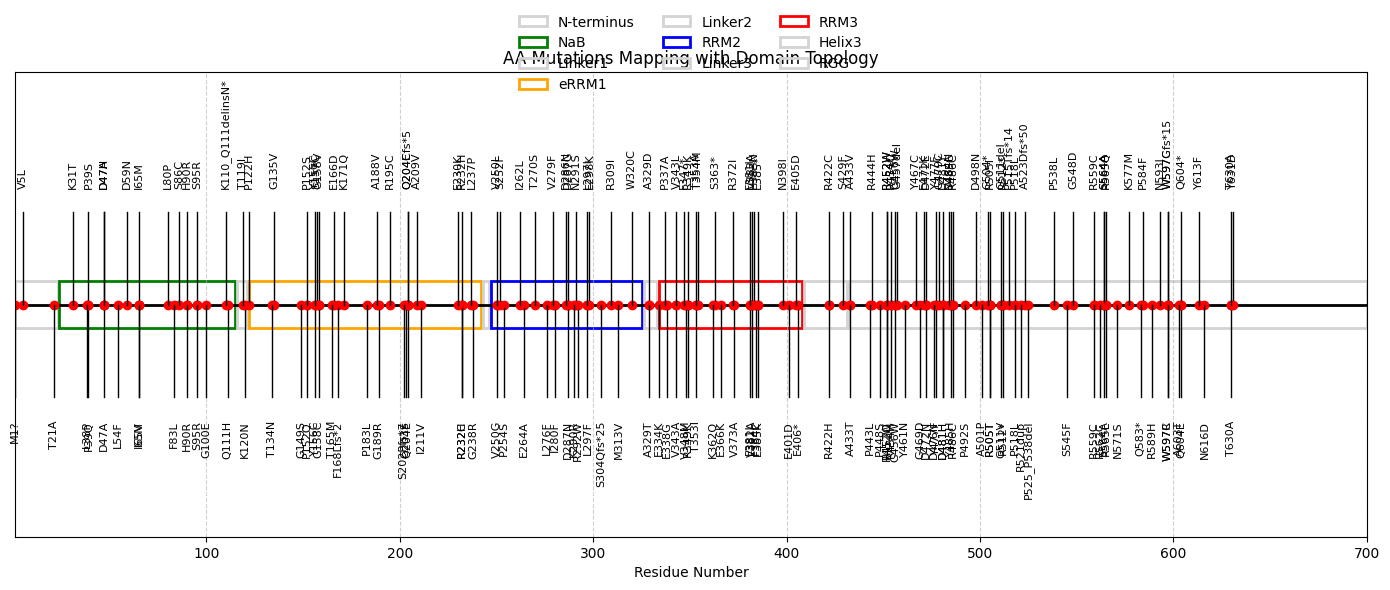

Plot saved as SVG at: plots/hnRNPR_variant_mapping_all.svg


In [6]:
#@title Map all mutations on full-length hnRNPR

import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure the 'plots' directory exists
os.makedirs('plots', exist_ok=True)

# Read the categorized mutation data CSV file
input_file = '/content/categorized_hnRNPR_mutations.csv'
df = pd.read_csv(input_file)

# Filter out rows where AA Mutation contains '=' (optional)
df_non_equal = df[~df['AA Mutation'].str.contains('=', na=False)]

# Define the new domain topology with specified colors
domain_topology = {
    "N-terminus": (1, 23, "lightgrey"),
    "NaB": (24, 115, "green"),
    "Linker1": (116, 121, "lightgrey"),
    "eRRM1": (122, 242, "orange"),
    "Linker2": (243, 246, "lightgrey"),
    "RRM2": (247, 325, "blue"),
    "Linker3": (326, 333, "lightgrey"),
    "RRM3": (334, 408, "red"),
    "Helix3": (409, 431, "lightgrey"),
    "RGG": (432, 700, "lightgrey")
}

# Create a figure
plt.figure(figsize=(14, 6))

# Plot the full-length protein timeline as a horizontal line
residue_range = range(1, 701)
plt.plot(residue_range, [0] * len(residue_range), color='black', lw=2)

# Add rectangles for each domain
for domain, (start, end, color) in domain_topology.items():
    plt.gca().add_patch(
        plt.Rectangle(
            (start, -0.01),  # Bottom-left corner of the rectangle
            end - start,    # Width of the rectangle
            0.02,           # Height of the rectangle
            edgecolor=color,
            facecolor="none",
            linewidth=2,
            label=domain
        )
    )

# Alternate label placement above and below the timeline
label_toggle = True

# Plot each AA mutation along the timeline
for idx, row in df_non_equal.iterrows():
    residue_number = row['Residue Number']
    aa_mutation = row['AA Mutation']

    # Remove "p." from the mutation label
    mutation_label = aa_mutation.lstrip('p.')

    # Plot the mutation
    plt.plot(residue_number, 0, 'ro')  # Red mark for mutation

    # Alternate label placement above and below the line
    if label_toggle:
        y_offset = 0.05
        va = 'bottom'
    else:
        y_offset = -0.05
        va = 'top'

    # Draw a line connecting the label to the red dot
    plt.plot([residue_number, residue_number], [0, y_offset - (0.01 if y_offset > 0 else -0.01)], color='black', lw=1)

    # Place the label slightly offset
    plt.text(residue_number, y_offset, mutation_label, rotation=90, ha='center', va=va, fontsize=8)

    # Toggle the placement for the next label
    label_toggle = not label_toggle

# Customize the plot
plt.xlim(1, 700)  # Set x-axis limits for the full-length protein
plt.ylim(-0.1, 0.1)  # Set y-axis limits for better spacing
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("Residue Number")
plt.title("AA Mutations Mapping with Domain Topology")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False)  # Legend for domains
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Save the plot as an SVG
output_svg_file = 'plots/hnRNPR_variant_mapping_all.svg'
plt.tight_layout()
plt.savefig(output_svg_file, format='svg')
plt.show()
plt.close()

print(f"Plot saved as SVG at: {output_svg_file}")


<ipython-input-7-c87a2b0738f1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_equal_star['AA Mutation'] = df_non_equal_star['AA Mutation'].str.strip()


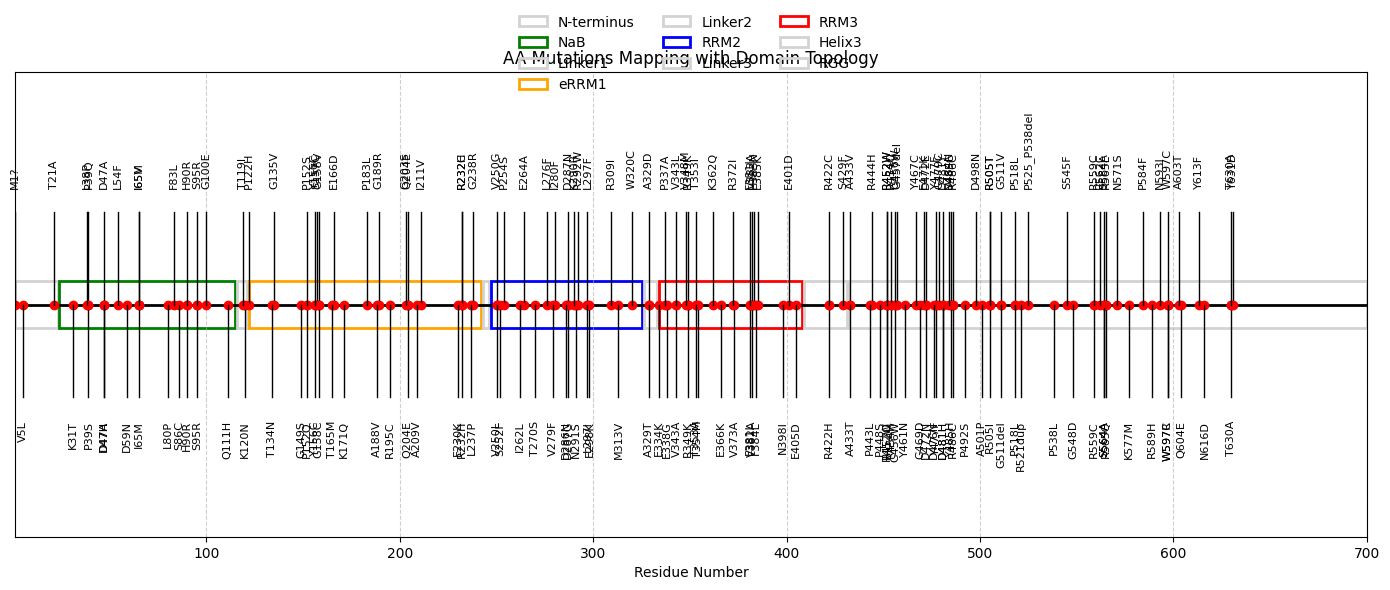

Plot saved as SVG at: plots/hnRNPR_variant_mapping_all-missense.svg


In [7]:
#@title Map missense mutations onto full-length hnRNPR

import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure the 'plots' directory exists
os.makedirs('plots', exist_ok=True)

# Read the categorized mutation data CSV file
input_file = '/content/categorized_hnRNPR_mutations.csv'
df = pd.read_csv(input_file)

# Filter out rows where AA Mutation contains '=' or '*' (optional)
df_non_equal_star = df[~df['AA Mutation'].str.contains('[=*]', na=False, regex=True)]

# Check for leading/trailing whitespaces in the 'AA Mutation' column and strip them
df_non_equal_star['AA Mutation'] = df_non_equal_star['AA Mutation'].str.strip()

# Proceed with the rest of the plot generation using df_non_equal_star

# Define the new domain topology with specified colors
domain_topology = {
    "N-terminus": (1, 23, "lightgrey"),
    "NaB": (24, 115, "green"),
    "Linker1": (116, 121, "lightgrey"),
    "eRRM1": (122, 242, "orange"),
    "Linker2": (243, 246, "lightgrey"),
    "RRM2": (247, 325, "blue"),
    "Linker3": (326, 333, "lightgrey"),
    "RRM3": (334, 408, "red"),
    "Helix3": (409, 431, "lightgrey"),
    "RGG": (432, 700, "lightgrey")
}

# Create a figure
plt.figure(figsize=(14, 6))

# Plot the full-length protein timeline as a horizontal line
residue_range = range(1, 701)
plt.plot(residue_range, [0] * len(residue_range), color='black', lw=2)

# Add rectangles for each domain
for domain, (start, end, color) in domain_topology.items():
    plt.gca().add_patch(
        plt.Rectangle(
            (start, -0.01),  # Bottom-left corner of the rectangle
            end - start,    # Width of the rectangle
            0.02,           # Height of the rectangle
            edgecolor=color,
            facecolor="none",
            linewidth=2,
            label=domain
        )
    )

# Alternate label placement above and below the timeline
label_toggle = True

# Plot each AA mutation along the timeline
for idx, row in df_non_equal_star.iterrows():
    residue_number = row['Residue Number']
    aa_mutation = row['AA Mutation']

    # Remove "p." from the mutation label
    mutation_label = aa_mutation.lstrip('p.')

    # Plot the mutation
    plt.plot(residue_number, 0, 'ro')  # Red mark for mutation

    # Alternate label placement above and below the line
    if label_toggle:
        y_offset = 0.05
        va = 'bottom'
    else:
        y_offset = -0.05
        va = 'top'

    # Draw a line connecting the label to the red dot
    plt.plot([residue_number, residue_number], [0, y_offset - (0.01 if y_offset > 0 else -0.01)], color='black', lw=1)

    # Place the label slightly offset
    plt.text(residue_number, y_offset, mutation_label, rotation=90, ha='center', va=va, fontsize=8)

    # Toggle the placement for the next label
    label_toggle = not label_toggle

# Customize the plot
plt.xlim(1, 700)  # Set x-axis limits for the full-length protein
plt.ylim(-0.1, 0.1)  # Set y-axis limits for better spacing
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("Residue Number")
plt.title("AA Mutations Mapping with Domain Topology")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False)  # Legend for domains
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Save the plot as an SVG
output_svg_file = 'plots/hnRNPR_variant_mapping_all-missense.svg'
plt.tight_layout()
plt.savefig(output_svg_file, format='svg')
plt.show()
plt.close()

print(f"Plot saved as SVG at: {output_svg_file}")


# Generate analysis and plots for eRRM1 domain

In [8]:
#@title Plot Distribution of Tissue Types in eRRM1 Mutations

import pandas as pd
import matplotlib.pyplot as plt

## Read the eRRM1_mutation_data.csv file
input_file = '/content/eRRM1_mutation_data.csv'
df = pd.read_csv(input_file)

# Count the residues that contain '='
equal_mutations = df[df['AA Mutation'].str.contains('=', na=False)]

# Count the residues that do not contain '='
non_equal_mutations = df[~df['AA Mutation'].str.contains('=', na=False)]

# Print the count of residues that contain '='
print(f"Count of residues that contain '=': {len(equal_mutations)}")

# Print the count of residues that do not contain '='
print(f"Count of residues that do not contain '=': {len(non_equal_mutations)}")
# Categorize by Primary Tissue and count occurrences
tissue_counts = filtered_df['Primary Tissue'].value_counts()

# Print the count and percentage for each tissue type
print("Tissue Type Counts and Percentages:")
for tissue, count in tissue_counts.items():
    percentage = (count / tissue_counts.sum()) * 100
    print(f"{tissue}: {count} ({percentage:.2f}%)")

# Create a pie chart of tissue types
plt.figure(figsize=(8, 8))
plt.pie(tissue_counts, labels=tissue_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Tissue Types in eRRM1 Mutations')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/eRRM1_mutation_data.csv'

In [ ]:
#@title Plot Distribution of Histology Types in eRRM1 Mutations

import pandas as pd
import matplotlib.pyplot as plt

# Read the eRRM1_mutation_data.csv file
input_file = '/content/eRRM1_mutation_data.csv'
df = pd.read_csv(input_file)

# Count the residues that contain '='
equal_mutations = df[df['AA Mutation'].str.contains('=', na=False)]

# Count the residues that do not contain '='
non_equal_mutations = df[~df['AA Mutation'].str.contains('=', na=False)]

# Print the count of residues that contain '='
print(f"Count of residues that contain '=': {len(equal_mutations)}")

# Print the count of residues that do not contain '='
print(f"Count of residues that do not contain '=': {len(non_equal_mutations)}")


# Categorize by Primary Tissue and count occurrences
tissue_counts = filtered_df['Histology Subtype 1'].value_counts()

# Print the count and percentage for each tissue type
print("Histology subtype Counts and Percentages:")
for tissue, count in tissue_counts.items():
    percentage = (count / tissue_counts.sum()) * 100
    print(f"{tissue}: {count} ({percentage:.2f}%)")

# Create a pie chart of tissue types
plt.figure(figsize=(8, 8))
plt.pie(tissue_counts, labels=tissue_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Histology Types in eRRM1 Mutations')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


In [ ]:
#@title Map missense mutations on eRRM1 to scale

import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure plots directory exists
os.makedirs('plots', exist_ok=True)

# Read the eRRM1 mutation data CSV file
input_file = '/content/eRRM1_mutation_data.csv'
df = pd.read_csv(input_file)

# Filter out rows where AA Mutation contains '=' (optional)
df_non_equal = df[~df['AA Mutation'].str.contains('=', na=False)]

# Set the residue number range (121 to 246)
residue_range = range(121, 246)

# Create a figure
plt.figure(figsize=(12, 6))

# Plot the residue timeline as a horizontal line
plt.plot(residue_range, [0] * len(residue_range), color='black', lw=2)
label_position = True

# Plot each AA mutation along the timeline
for idx, row in df_non_equal.iterrows():
    residue_number = row['Residue Number']
    aa_mutation = row['AA Mutation']

    # Remove "p." from the mutation label
    mutation_label = aa_mutation.lstrip('p.')

    # If residue is in the range 121-246, plot it
    if 121 <= residue_number <= 246:
        plt.plot(residue_number, 0, 'ro')  # Red mark for mutation

        # Draw a line connecting the label to the red dot
        line_height = 0.05 if label_position else -0.05
        plt.plot([residue_number, residue_number], [0, line_height], color='black', lw=1)  # Line from dot to label

        # Place the label slightly above or below the line
        text_height = 0.07 if label_position else -0.07
        plt.text(residue_number, text_height, mutation_label, rotation=90, ha='center', va='bottom', fontsize=8)

        # Alternate the label position
        label_position = not label_position

# Customize the plot
plt.xlim(121, 246)  # Set x-axis limits
plt.ylim(-0.1, 0.1)  # Set y-axis limits for better spacing
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("Residue Number")
plt.title("AA Mutations (Residues 121-246)")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Save the plot as an SVG
output_svg_file = 'plots/eRRM1_missense_map.svg'
plt.tight_layout()
plt.savefig(output_svg_file, format='svg')
plt.show()
plt.close()

print(f"Plot saved as SVG at: {output_svg_file}")


In [ ]:
#@title zip data for download

import shutil

# Path to the directory you want to zip
directory_to_zip = '/content'
# Path to the output zip file
zip_filename = '/content/COSMIC_output.zip'

# Create a zip file
shutil.make_archive('/content/COSMIC_output', 'zip', directory_to_zip)
